In [1]:
import numpy as np
import pandas as pd

In [ ]:
raw_df = pd.read_excel("../data/proshares_analysis_data.xlsx", sheet_name = 'hedge_fund_series', index_col = 0)
bench_df = pd.read_excel("../data/proshares_analysis_data.xlsx", sheet_name = 'merrill_factors', index_col = 0)


,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
2011-08-31,-0.054976,0.000009,-0.092550,-0.087547,-0.005889,-0.088914
2011-09-30,-0.069420,0.000017,-0.179063,-0.108085,0.142180,-0.111506
2011-10-31,0.109147,-0.000013,0.162986,0.096277,-0.069502,0.151011
2011-11-30,-0.004064,0.000000,-0.019724,-0.021764,0.054627,-0.003783
2011-12-31,0.010450,0.000009,-0.042649,-0.021745,0.075581,0.005144


In [ ]:
# 2.1 For the series in the “hedge fund series” tab, report the following summary statistics:mean、volatility、Sharpe ratio, Annualize these statistics.
frequent = 12
mv = raw_df.mean() *frequent
vol = raw_df.std() * np.sqrt(frequent)
Sharp = mv/vol
Table = pd.concat([mv, vol, Sharp], axis=1, keys= ["Mean_Return", "Volatility", "Sharp_Ratio"])
Table


,Mean_Return,Volatility,Sharp_Ratio
HFRIFWI Index,0.051279,0.058796,0.872151
MLEIFCTR Index,0.038535,0.055240,0.697589
MLEIFCTX Index,0.036526,0.055102,0.662880
HDG US Equity,0.026880,0.057388,0.468396
QAI US Equity,0.028811,0.049823,0.578275


In [22]:
#2.2 For the series in the “hedge fund series” tab, calculate the following statistics related to tail-risk.
skew = raw_df.skew()
kurt = raw_df.kurt()
Var_dic = {}
CVar_dic = {}
#Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.
Maxdown_dic = {}
Maxdate_dic = {}
Mindate_dic = {}
Recoverydate_dic = {}
Ticks = list(raw_df.columns)
for tick in Ticks:
    Var_num = raw_df[tick].quantile(0.05)
    CVar_num = raw_df[tick][raw_df[tick] <= Var_num].mean()
    Var_dic[tick] = Var_num
    CVar_dic[tick] = CVar_num

    cum_balance = (1+raw_df[tick]).cumprod()
    max_history = cum_balance.cummax()
    drowdown = cum_balance- max_history
    Maxdown_num = drowdown.min()
    Maxdown_dic[tick] = Maxdown_num
    Mindate = drowdown.index[drowdown == Maxdown_num][0]
    Maxdate = cum_balance.index[cum_balance == max_history[Mindate]][0]
    Recoverydate = max_history.index[max_history > max_history[Mindate]][0]
    Maxdate_dic[tick] = Maxdate
    Mindate_dic[tick] = Mindate
    Recoverydate_dic[tick] = Recoverydate

Var = pd.DataFrame.from_dict(Var_dic, orient= 'index', columns= ['Var_5%'])
CVar = pd.DataFrame.from_dict(CVar_dic, orient= 'index', columns= ['CVar_5%'])
Max_drawdown = pd.DataFrame.from_dict(Maxdown_dic, orient= 'index', columns= ['Maximum_Drawdown'])
Max_Date = pd.DataFrame.from_dict(Maxdate_dic, orient= 'index', columns= ['Max_Date'])
Min_Date = pd.DataFrame.from_dict(Mindate_dic, orient= 'index', columns= ['Min_Date'])
Recovery_Date = pd.DataFrame.from_dict(Recoverydate_dic, orient= 'index', columns= ['Recovery_Date'])

skew = pd.DataFrame(skew, columns= ['Skew'])
kurt = pd.DataFrame(kurt, columns= ['Kurt_ex'])
Risk_Table = pd.concat([skew, kurt, Var, CVar, Max_drawdown, Max_Date, Min_Date, Recovery_Date], axis=1)
Risk_Table

,Skew,Kurt_ex,Var_5%,CVar_5%,Maximum_Drawdown,Max_Date,Min_Date,Recovery_Date
HFRIFWI Index,-0.948272,5.657351,-0.024008,-0.035992,-0.154223,2019-12-31,2020-03-31,2020-08-31
MLEIFCTR Index,-0.289982,1.630917,-0.027002,-0.034993,-0.185640,2021-06-30,2022-09-30,2024-02-29
MLEIFCTX Index,-0.273477,1.589790,-0.026970,-0.034937,-0.182959,2021-06-30,2022-09-30,2024-02-29
HDG US Equity,-0.274904,1.776481,-0.029919,-0.036831,-0.187781,2021-06-30,2022-09-30,2024-07-31
QAI US Equity,-0.433508,1.449184,-0.017171,-0.030995,-0.179332,2021-06-30,2022-09-30,2024-02-29


In [ ]:
# 2.3 For the series in the “hedge fund series” tab, run a regression of each against SPY (found in the “merrill factors” tab.) Include an intercept. Report the following regression-based statistics:
#Market Beta
#Treynor Ratio (assume rf = 0)
#Information ratio
#Annualize these three statistics as appropriate.

import statsmodels.api as sm


In [31]:
Beta_dic = {}
Treynor_dic = {}
Info_dic = {}
Alpha_dic = {}
for tick in Ticks:
    X = bench_df['SPY US Equity']
    X = sm.add_constant(X)
    y = raw_df[tick]
    X = X.loc[ X.notnull().all(axis = 1) & y.notnull()]
    y = y.loc[ X.notnull().all(axis = 1) & y.notnull()]
    model = sm.OLS(y, X)
    result = model.fit()
    Treynor_num = y.mean()/ result.params['SPY US Equity'] * frequent
    Alpha_num = result.params['const'] * frequent
    Beta_num = result.params['SPY US Equity']
    Info_num = result.params['const'] / result.resid.std() * np.sqrt(frequent)
    Beta_dic[tick] = Beta_num
    Treynor_dic[tick] = Treynor_num
    Info_dic[tick] = Info_num
    Alpha_dic[tick] = Alpha_num

#Ratio_Table = pd.DataFrame.from_dict([Beta_dic, Treynor_dic, Info_dic], orient= 'index', columns= ["Market Beta", "Treynor Ratio", "Information Ratio"])
Ratio_Table = pd.DataFrame.from_dict({"Alpha" : Alpha_dic ,"Market Beta": Beta_dic, "Treynor Ratio":Treynor_dic, "Information Ratio": Info_dic})
Ratio_Table


,Alpha,Market Beta,Treynor Ratio,Information Ratio
HFRIFWI Index,0.001733,0.346312,0.148072,0.055336
MLEIFCTR Index,-0.011037,0.342487,0.112514,-0.436440
MLEIFCTX Index,-0.012900,0.341483,0.106963,-0.510548
HDG US Equity,-0.023866,0.350602,0.076669,-0.862386
QAI US Equity,-0.014815,0.301413,0.095587,-0.597796


In [ ]:
# 2.4 Discuss the previous statistics, and what they tell us about…

#the differences between SPY and the hedge-fund series?
# A:Information shows that almost all the hedge-fund series perform worse than SPY.

#which performs better between HDG and QAI.
# A: QAI performs better in terms of Treynor Ratio and Information Ratio.

#whether HDG and the ML series capture the most notable properties of HFRI.
# A: No, HFRI has positive Information Ratio. The other series do not capture that.

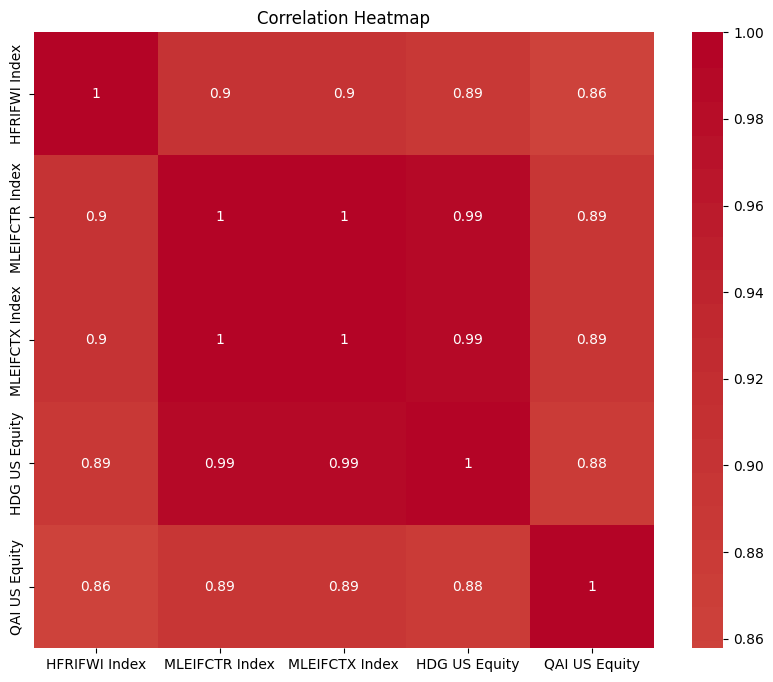

In [ ]:
# 2.5 Show the correlations as a heat map.
import matplotlib.pyplot as plt
import seaborn as sns

corr = raw_df.corr()

# 畫出熱圖
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

#Which series have the highest and lowest correlations?
# A: MLEIFCTR Index and MLEIFCTX Index has the highest correlation, and it is 1.00. HFRIFWI Index and QAI US Equity has the lowest correlation, but 0.86 is still high.

In [33]:
# 2.6 Replicate HFRI with the six factors listed on the “merrill factors” tab. Include a constant, and run the unrestricted regression
X = bench_df
X = sm.add_constant(X)
y = raw_df['HFRIFWI Index']
X = X.loc[y.notnull() & X.notnull().all(axis= 1)]
y = y.loc[y.notnull() & X.notnull().all(axis= 1)]
model = sm.OLS(y, X)
result = model.fit()


In [ ]:
#a. Report the intercept and betas.
result.params
#b. Are the betas realistic position sizes, or do they require huge long-short positions?
# A: They are pretty realistic position sizes, nothing too huge, and also no need to short.

const            0.001149
SPY US Equity    0.043503
USGG3M Index     0.324931
EEM US Equity    0.085564
EFA US Equity    0.073994
EUO US Equity    0.029614
IWM US Equity    0.145824
dtype: float64

In [35]:
#c. Report the R-squared.
result.rsquared


np.float64(0.8426938827413941)

In [36]:
#d. Report the volatility of the tracking error.
result.resid.std()

np.float64(0.006731819236592867)

In [ ]:
# 2.7 Let’s examine the replication out-of-sample (OOS).
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# t= 1 ~ 60, estimate the regression equation.
X = bench_df
X = sm.add_constant(X)
y = raw_df['HFRIFWI Index']
X = X.loc[y.notnull() & X.notnull().all(axis= 1)]
y = y.loc[y.notnull() & X.notnull().all(axis= 1)]

y_test = y.iloc[60:]
y_pred = pd.Series(index = y_test.index, dtype = float)

for i in range(60 ,len(X)):
    X_train = X.iloc[i-60:i]
    y_train = y.iloc[i-60:i]
    model = LinearRegression().fit(X_train, y_train)
    y_pred.iloc[i-60] = model.predict(X.iloc[i].values.reshape(1, -1))


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R2: ", r2, ",MSE: ", mse) ## 2.7 Let’s examine the replication out-of-sample (OOS).
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# t= 1 ~ 60, estimate the regression equation.
X = bench_df
X = sm.add_constant(X)
y = raw_df['HFRIFWI Index']
X = X.loc[y.notnull() & X.notnull().all(axis= 1)]
y = y.loc[y.notnull() & X.notnull().all(axis= 1)]

y_test = y.iloc[60:]
y_pred = pd.Series(index = y_test.index, dtype = float)

for i in range(60 ,len(X)):
    X_train = X.iloc[i-60:i]
    y_train = y.iloc[i-60:i]
    model = LinearRegression().fit(X_train, y_train)
    y_pred.iloc[i-60] = model.predict(X.iloc[i].values.reshape(1, -1))


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R2: ", r2, ",MSE: ", mse) #R2:  0.8054731071298435 ,MSE:  6.433898972656934e-05
# How well does the out-of-sample replication perform with respect to the target?
# Pretty well, in terms of R_sqaure and MSE


R2:  0.8054731071298435 ,MSE:  6.433898972656934e-05


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749